In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import math
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from tensorflow.keras.optimizers import Adam
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import accuracy_score, f1_score
plt.style.use("seaborn-v0_8")
from sklearn.preprocessing import MinMaxScaler


In [12]:
# === Step 1: Load CSV ===
csv_path = "/content/DMC2_S_CP2_52.csv"
df = pd.read_csv(csv_path)
print("✅ Step 1 - Loaded CSV Shape:", df.shape)

# === Step 2: Extract 'CURRENT|6' column as univariate input x ===
target_col = "CURRENT|6"

x = df[[target_col]].values  # shape: (T, 1)
print("✅ Step 2 - Extracted x shape:", x.shape)

# === Step 3: Normalize x using MinMaxScaler ===
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
print("✅ Step 3 - Normalized x. Shape:", x_scaled.shape)

✅ Step 1 - Loaded CSV Shape: (42016, 56)
✅ Step 2 - Extracted x shape: (42016, 1)
✅ Step 3 - Normalized x. Shape: (42016, 1)


In [13]:
# === Step 4: Create sliding windows ===
dim = 16          # Model dimension (used for projecting input)
window_size = 60

def create_sliding_windows(data, window_size):
    return np.array([data[i:i + window_size] for i in range(len(data) - window_size)])

# shape: [N_windows, window_size, 1]
X_all = create_sliding_windows(x_scaled, window_size)
print("✅ Step 4 - Created sliding windows. Shape:", X_all.shape)



✅ Step 4 - Created sliding windows. Shape: (41956, 60, 1)


In [14]:
# === Step 5: Chronological Train-Test Split (60% - 40%) ===
n_total = X_all.shape[0]
n_train = int(n_total * 0.6)

X_train = X_all[:n_train]  # First 60%
X_test = X_all[n_train:]   # Remaining 40%

print("✅ Step 5 - Train/Test split")
print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

✅ Step 5 - Train/Test split
Train shape: (25173, 60, 1)
Test shape : (16783, 60, 1)


In [15]:
# === Step 6: Convert to PyTorch tensors ===
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # [B, T, 1]
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

print("\n\n✅ Step 6 - Converted to torch tensors.")
print("X_train_tensor:", X_train_tensor.shape)
print("X_test_tensor :", X_test_tensor.shape)




✅ Step 6 - Converted to torch tensors.
X_train_tensor: torch.Size([25173, 60, 1])
X_test_tensor : torch.Size([16783, 60, 1])


In [16]:
"""## Config , Hyperparameters"""

# 🧠 hyperparameters & Config
FEATS = 1                  # Input feature dimension
DIM_FEEDFORWARD = 64       # Hidden units in FFN
NUM_HEADS = 1              # Attention heads (must divide D_MODEL)
NUM_ENCODER_LAYERS = 1     # Transformer encoder layers
NUM_DECODER_LAYERS = 1     # Transformer decoder layers
DROPOUT = 0.1              # Dropout rate

D_MODEL = dim
window_size = window_size

batch_size = 128
num_epochs = 50
lr = 0.001
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)  # create the folder if it doesn't exist


print("\nDONE - Config")


DONE - Config


In [17]:
"""## Model"""

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=DROPOUT, max_len=500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create sinusoidal positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices, cosine to odd indices
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term[:(d_model // 2 + 1)])  # handles both even/odd d_model

        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # Add positional encoding to input tensor
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


class PeakAD_Transformer(nn.Module):
    def __init__(self):
        super().__init__()

        # Project input features into higher dimension
        self.input_proj = nn.Linear(FEATS, D_MODEL)

        # Add positional encoding for combined input + error sequence
        self.pos_encoder = PositionalEncoding(D_MODEL * 2, DROPOUT, window_size)

        # Define encoder block
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=D_MODEL * 2,
            nhead=NUM_HEADS,
            dim_feedforward=DIM_FEEDFORWARD,
            dropout=DROPOUT,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=NUM_ENCODER_LAYERS)

        # Define decoder block
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=D_MODEL * 2,
            nhead=NUM_HEADS,
            dim_feedforward=DIM_FEEDFORWARD,
            dropout=DROPOUT,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=NUM_DECODER_LAYERS)

        # Output layer to project back to original feature dimension
        self.output_layer = nn.Sequential(
            nn.Linear(D_MODEL * 2, FEATS),
            nn.Sigmoid()
        )

    def encode(self, src, err, tgt):
        # Project source and error
        src_enc = self.input_proj(src)
        err_enc = self.input_proj(err)

        # Concatenate source and error for self-conditioning
        combined = torch.cat((src_enc, err_enc), dim=2)
        combined = combined * math.sqrt(D_MODEL)

        # Add positional encoding
        encoded = self.pos_encoder(combined)

        # Pass through transformer encoder
        memory = self.encoder(encoded)

        # Project and duplicate target for decoding
        tgt_proj = self.input_proj(tgt)
        tgt_combined = torch.cat((tgt_proj, tgt_proj), dim=2)

        return tgt_combined, memory

    def forward(self, src, tgt):
        # Phase 1: Without anomaly signal
        err = torch.zeros_like(src)
        tgt1, mem1 = self.encode(src, err, tgt)
        x1 = self.output_layer(self.decoder(tgt1, mem1))

        # Phase 2: With self-conditioning using reconstruction error
        err = (x1 - src) ** 2
        tgt2, mem2 = self.encode(src, err, tgt)
        x2 = self.output_layer(self.decoder(tgt2, mem2))

        return x2  # Final reconstructed sequence


In [18]:

"""## Model Training"""

model = PeakAD_Transformer()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=batch_size, shuffle=True)

# previous checkpoint to resume from
start_epoch = 1  # default

# Find checkpoint files matching current config
checkpoint_files = [f for f in os.listdir(checkpoint_dir)
                    if f"Ws{window_size}_Dim{D_MODEL}" in f]

# Load latest checkpoint if available
if checkpoint_files:
    # Sort files based on the epoch number extracted correctly from the filename
    latest_checkpoint = sorted(checkpoint_files, key=lambda x: int(x.split("_")[2]))[-1]

    checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1

    print(f"🔁 Resuming training from epoch {start_epoch} (loaded {latest_checkpoint})")

# Training loop
model.train()
for epoch in range(start_epoch, num_epochs + 1):
    print("Training Started")
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        x2 = model(xb, xb)
        loss = criterion(x2, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss:.4f}")

    # Save checkpoint every 50 epochs
    if epoch % 10 == 0 or epoch == num_epochs:
        ckpt_path = f"checkpoint_epoch_{epoch}_Ws{window_size}_Dim{D_MODEL}.pt"
        checkpoint_path = os.path.join(checkpoint_dir, ckpt_path)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_path)
        print(f"Checkpoint saved at: {checkpoint_path}")

print("DONE: Training complete")

🔁 Resuming training from epoch 51 (loaded checkpoint_epoch_50_Ws60_Dim16.pt)
DONE: Training complete


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [19]:
def get_last_timestep_reconstruction_error(model, scaler, X_tensor, start_index_offset=0):
    model.eval()
    with torch.no_grad():
        recon = model(X_tensor, X_tensor)
        recon_last = recon[:, -1, 0].cpu().numpy()
        true_last = X_tensor[:, -1, 0].cpu().numpy()

        recon_orig = scaler.inverse_transform(recon_last.reshape(-1, 1)).flatten()
        true_orig = scaler.inverse_transform(true_last.reshape(-1, 1)).flatten()
        errors = np.abs(true_orig - recon_orig)

        # Timestamps: from offset (e.g., 30) to offset + len
        timestamp_indices = np.arange(start_index_offset, start_index_offset + len(true_orig))

        df = pd.DataFrame({
            "Timestamp": timestamp_indices,
            "True_Value": true_orig,
            "Reconstructed_Value": recon_orig,
            "Reconstruction_Error": errors
        })

        return df

In [20]:
print("\n⚙️ Calculating reconstruction error for TRAIN data...")
train_df = get_last_timestep_reconstruction_error(
    model, scaler, X_train_tensor, start_index_offset=window_size
)

print("✅ Train RE calculated:", train_df.shape)

print("\n⚙️ Calculating reconstruction error for TEST data...")
test_df = get_last_timestep_reconstruction_error(
    model, scaler, X_test_tensor, start_index_offset=window_size + len(train_df)
)

print("✅ Test RE calculated:", test_df.shape)

# Combine train + test RE into full RE dataset
full_df = pd.concat([train_df, test_df], ignore_index=True)

# Compute threshold on full RE
threshold = np.percentile(full_df["Reconstruction_Error"], 98)
full_df["Peak"] = (full_df["Reconstruction_Error"] > threshold).astype(int)

# Save the full reconstruction error as a CSV
output_path = f"/content/Full_Reconstruction_Error_Ws{window_size}_Dim{D_MODEL}.csv"
full_df.to_csv(output_path, index=False)

print(f"\n📦 Saved full reconstruction error with peaks to: {output_path}")
print(f"📊 Total points: {len(full_df)} | Peaks: {full_df['Peak'].sum()} | Threshold: {threshold:.6f}")


⚙️ Calculating reconstruction error for TRAIN data...
✅ Train RE calculated: (25173, 4)

⚙️ Calculating reconstruction error for TEST data...
✅ Test RE calculated: (16783, 4)

📦 Saved full reconstruction error with peaks to: /content/Full_Reconstruction_Error_Ws60_Dim16.csv
📊 Total points: 41956 | Peaks: 840 | Threshold: 0.079899


In [21]:
# Load your original dataset (with all 53 columns, including target)
df_full_original = pd.read_csv("/content/DMC2_S_CP2_52.csv")

# Ensure the shape is as expected
print("Original full dataset shape:", df_full_original.shape)

Original full dataset shape: (42016, 56)


In [22]:
full_df = pd.read_csv(f"/content/Full_Reconstruction_Error_Ws{window_size}_Dim{D_MODEL}.csv")

# Contains columns: ['Timestamp', 'True_Value', 'Reconstructed_Value', 'Reconstruction_Error', 'Peak']

In [23]:
# Merge on the Timestamp column
df_full_original["Timestamp"] = df_full_original.index  # If original dataset has no timestamp
merged_df = df_full_original.merge(full_df[["Timestamp", "Reconstruction_Error", "Peak"]],
                                   on="Timestamp", how="left")

# Fill NaN errors (initial rows where window couldn't compute) with 0 or suitable value
merged_df["Reconstruction_Error"] = merged_df["Reconstruction_Error"].fillna(0)
merged_df["Peak"] = merged_df["Peak"].fillna(0).astype(int)

print("✅ Merged dataset shape:", merged_df.shape)

✅ Merged dataset shape: (42016, 59)


In [24]:
# Save the final merged dataset as CSV
output_path = "/content/Merged_Dataset_Final.csv"
merged_df.to_csv(output_path, index=False)

print(f"📁 Final merged dataset saved to: {output_path}")

📁 Final merged dataset saved to: /content/Merged_Dataset_Final.csv


### Random Forest - Loss As a Feature

In [39]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Step 1: Load your merged dataset ===
data = pd.read_csv("/content/Merged_Dataset_Final.csv")

# === Step 2: Define columns to exclude ===
exclude_columns = ['CURRENT|1', 'CURRENT|2', 'CURRENT|3', 'Timestamp', 'Peak', 'CURRENT|6']
target_column = 'CURRENT|6'

# === Step 3: Define Features and Target ===
feature_columns = [col for col in data.columns if col not in exclude_columns]
X = data[feature_columns]
y = data[target_column]

print("✅ Final Feature Columns Used:", feature_columns)
print("📊 Total Features:", len(feature_columns))

print("Number of features:", X.shape[0], X.shape[1])



✅ Final Feature Columns Used: ['LOAD|1', 'LOAD|2', 'LOAD|3', 'LOAD|6', 'ENC_POS|1', 'ENC_POS|2', 'ENC_POS|3', 'ENC_POS|6', 'CTRL_DIFF2|1', 'CTRL_DIFF2|2', 'CTRL_DIFF2|3', 'CTRL_DIFF2|6', 'TORQUE|1', 'TORQUE|2', 'TORQUE|3', 'TORQUE|6', 'DES_POS|1', 'DES_POS|2', 'DES_POS|3', 'DES_POS|6', 'CTRL_DIFF|1', 'CTRL_DIFF|2', 'CTRL_DIFF|3', 'CTRL_DIFF|6', 'CTRL_POS|1', 'CTRL_POS|2', 'CTRL_POS|3', 'CTRL_POS|6', 'VEL_FFW|1', 'VEL_FFW|2', 'VEL_FFW|3', 'VEL_FFW|6', 'CONT_DEV|1', 'CONT_DEV|2', 'CONT_DEV|3', 'CONT_DEV|6', 'CMD_SPEED|1', 'CMD_SPEED|2', 'CMD_SPEED|3', 'CMD_SPEED|6', 'TORQUE_FFW|1', 'TORQUE_FFW|2', 'TORQUE_FFW|3', 'TORQUE_FFW|6', 'ENC1_POS|1', 'ENC1_POS|2', 'ENC1_POS|3', 'ENC1_POS|6', 'ENC2_POS|1', 'ENC2_POS|2', 'ENC2_POS|3', 'ENC2_POS|6', 'Reconstruction_Error']
📊 Total Features: 53
Number of features: 42016 53


In [32]:
# Chronological split (no shuffle)
split_idx = int(0.6 * len(X))

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

# 📏 Print dataset sizes
print("✅ Training Set Size:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("\n✅ Test Set Size:")
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)

✅ Training Set Size:
X_train: (25209, 53)
y_train: (25209,)

✅ Test Set Size:
X_test : (16807, 53)
y_test : (16807,)


In [33]:


# === Step 5: Train Random Forest Regressor ===
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# === Step 6: Predict and Evaluate ===
y_pred = rf_model.predict(X_test)



In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # ✅ Manual square root
r2 = r2_score(y_test, y_pred)

print("\n📊 Random Forest Regression Performance:")
print(f"MAE  (Mean Absolute Error) : {mae:.4f}")
print(f"MSE  (Mean Squared Error)  : {mse:.4f}")
print(f"RMSE (Root Mean Squared Error) : {rmse:.4f}")
print(f"R²   (R-squared Score)     : {r2:.4f}")


📊 Random Forest Regression Performance:
MAE  (Mean Absolute Error) : 0.1128
MSE  (Mean Squared Error)  : 0.7220
RMSE (Root Mean Squared Error) : 0.8497
R²   (R-squared Score)     : 0.9340


In [27]:
# Drop non-feature columns like Timestamp, Peak
correlation = merged_df.drop(columns=["Timestamp", "Peak"]).corr()

# Get correlation of each feature with the target
target_corr = correlation["CURRENT|6"].drop("CURRENT|6")  # Drop self-correlation

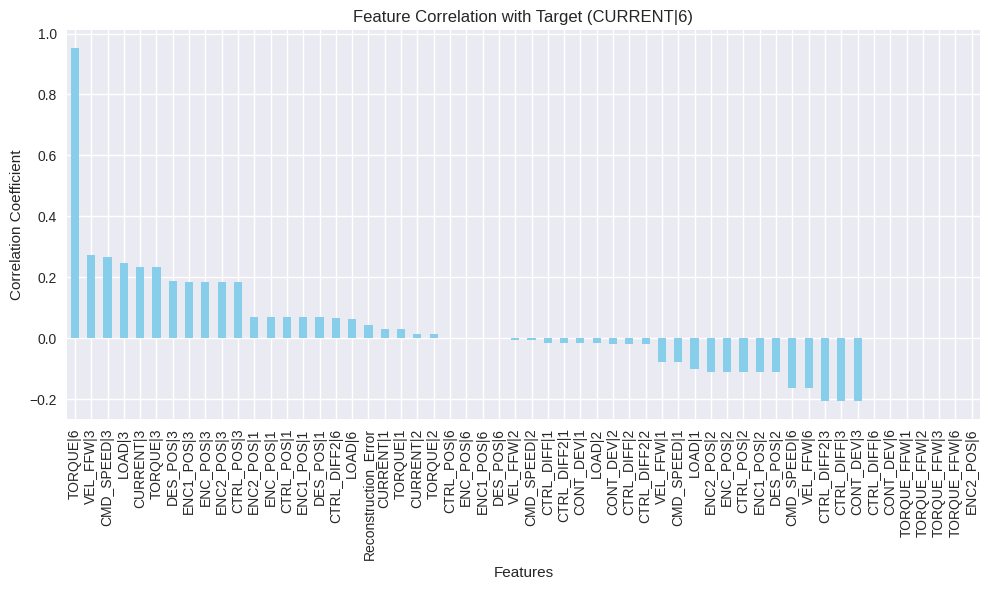

In [28]:
import matplotlib.pyplot as plt

# Sort values for better visualization
target_corr_sorted = target_corr.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
target_corr_sorted.plot(kind='bar', color='skyblue')
plt.title("Feature Correlation with Target (CURRENT|6)")
plt.xlabel("Features")
plt.ylabel("Correlation Coefficient")
plt.grid(True)
plt.tight_layout()
plt.show()

### Exclude Loss Feature

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 👇 Create a copy of the merged DataFrame to avoid modifying the original
df_no_loss = merged_df.copy()

# === Step 1: Drop unwanted columns ===
columns_to_drop = [
    "Timestamp",         # Not useful for prediction
    "Peak",              # It's a derived anomaly label
    "Reconstruction_Error",  # 🚫 You asked to remove this
    "CURRENT|1", "CURRENT|2", "CURRENT|3"
]

# Also drop the target variable temporarily to define features
X = df_no_loss.drop(columns=columns_to_drop + ['CURRENT|6'])

# === Step 2: Define target variable ===
y = df_no_loss['CURRENT|6']

print("Number of features:", X.shape[0], X.shape[1])



# === Step 3: Train Test Split ===
split_idx = int(0.6 * len(X))

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

# 📏 Print dataset sizes
print("✅ Training Set Size:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("\n✅ Test Set Size:")
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)

# === Step 4: Train Random Forest Regressor ===
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# === Step 5: Predict and Evaluate ===
y_pred = rf_model.predict(X_test)

# === Step 6: Evaluate Performance ===
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n📊 Random Forest Regression Performance (Without Reconstruction Error):")
print(f"MAE  (Mean Absolute Error)       : {mae:.4f}")
print(f"MSE  (Mean Squared Error)        : {mse:.4f}")
print(f"RMSE (Root Mean Squared Error)   : {rmse:.4f}")
print(f"R²   (R-squared Score)           : {r2:.4f}")

Number of features: 42016 52
✅ Training Set Size:
X_train: (25209, 52)
y_train: (25209,)

✅ Test Set Size:
X_test : (16807, 52)
y_test : (16807,)

📊 Random Forest Regression Performance (Without Reconstruction Error):
MAE  (Mean Absolute Error)       : 0.1244
MSE  (Mean Squared Error)        : 0.7020
RMSE (Root Mean Squared Error)   : 0.8379
R²   (R-squared Score)           : 0.9358


## Z-Score - Univariate

Number of anomalies flagged: 548


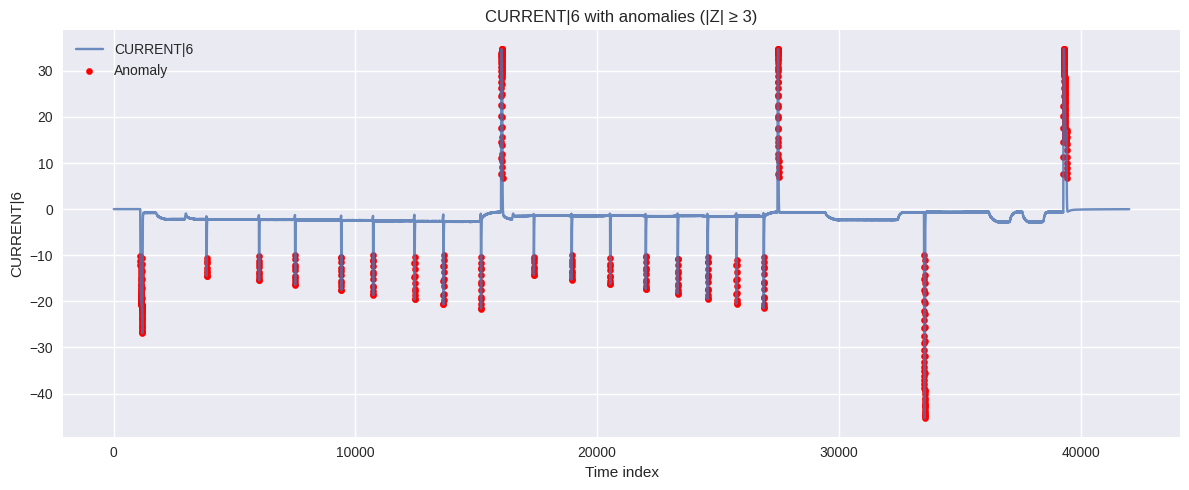

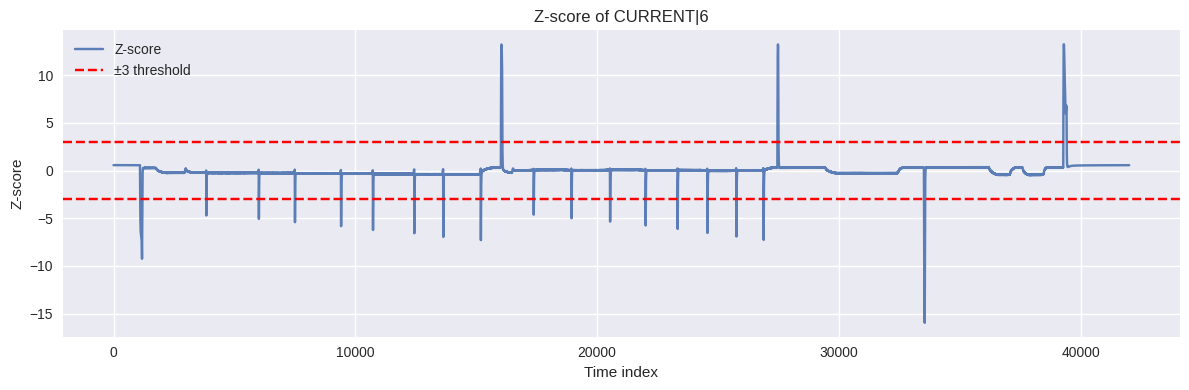

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load your data ---
df = pd.read_csv("/content/DMC2_S_CP2_52.csv")  # replace path
target = "CURRENT|6"               # change if needed

# --- Global Z-score (using whole series mean/std) ---
mu = df[target].mean()
sigma = df[target].std(ddof=0)  # population std; use ddof=1 for sample std
z = (df[target] - mu) / sigma

# --- Mark anomalies ---
thr = 3
anoms = np.abs(z) >= thr

# --- Count anomalies ---
num_anoms = anoms.sum()
print(f"Number of anomalies flagged: {num_anoms}")

# --- Plot ---
plt.figure(figsize=(12,5))
plt.plot(df[target].values, label=target, alpha=0.8)
plt.scatter(np.where(anoms)[0], df[target].values[anoms], color='red', s=20, label='Anomaly')
plt.title(f"{target} with anomalies (|Z| ≥ {thr})")
plt.xlabel("Time index")
plt.ylabel(target)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: plot the Z-score itself
plt.figure(figsize=(12,4))
plt.plot(z.values, label='Z-score', alpha=0.9)
plt.axhline(thr, color='r', linestyle='--')
plt.axhline(-thr, color='r', linestyle='--', label=f'±{thr} threshold')
plt.title(f"Z-score of {target}")
plt.xlabel("Time index")
plt.ylabel("Z-score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Z-score for Test

Z-score threshold: |Z| >= 2
Anomalies (test only): 285 (1.70%)
Peaks among anomalies (simple local maxima in |Z|): 6


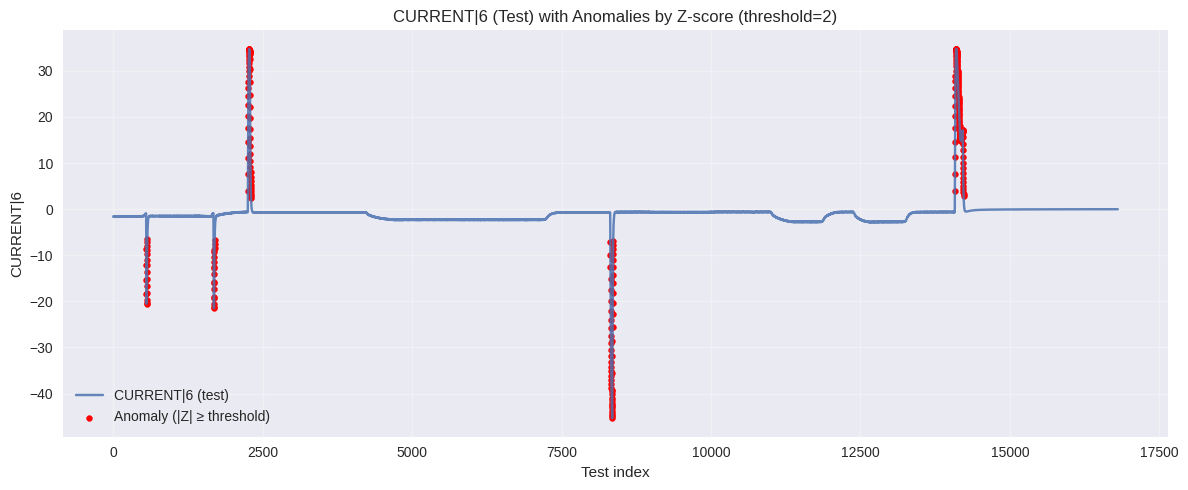

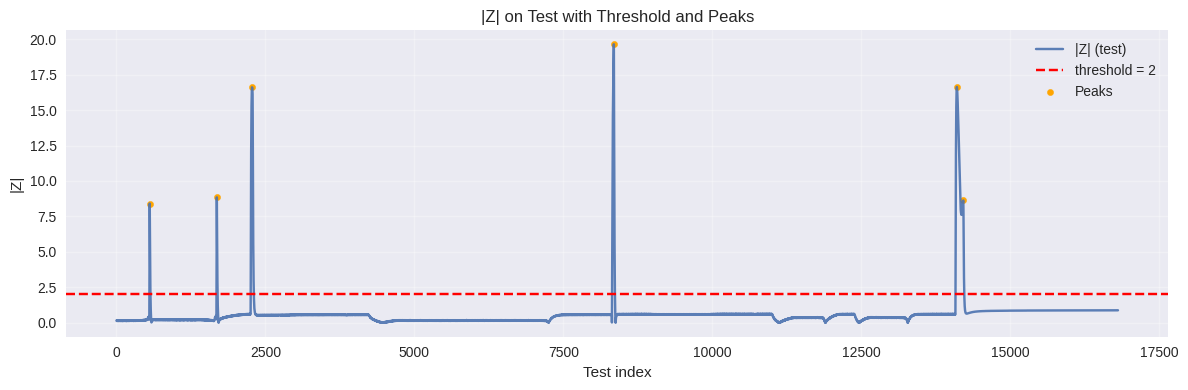

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==== CONFIG ====
csv_path = "/content/DMC2_S_CP2_52.csv"   # <-- change path
target   = "CURRENT|6"                    # <-- change target if needed
thr      = 2                           # fixed |Z|-threshold (as before)

# ==== LOAD ====
df = pd.read_csv(csv_path)
y = df[target].astype(float).reset_index(drop=True)

# ==== CHRONO SPLIT 60/40 ====
n = len(y)
split_idx = int(0.6 * n)
y_train = y.iloc[:split_idx].copy()
y_test  = y.iloc[split_idx:].copy()

# ==== Z-SCORE ON TEST (using TRAIN μ, σ) ====
mu = y_train.mean()
sigma = y_train.std(ddof=0)  # population std (keep same choice as before)
z_test = (y_test - mu) / (sigma if sigma != 0 else 1.0)
abs_z_test = z_test.abs()

# ==== ANOMALY MASK (|Z| >= thr) ====
anoms = abs_z_test >= thr
num_anoms = int(anoms.sum())
pct_anoms = 100.0 * anoms.mean()

print(f"Z-score threshold: |Z| >= {thr}")
print(f"Anomalies (test only): {num_anoms} ({pct_anoms:.2f}%)")

# ==== (Optional) Peak count among anomalies ====
# Define a simple local-peak: anomaly point whose |Z| is >= neighbors' |Z|
absz = abs_z_test.values
peak_idx = []
for i in range(len(absz)):
    if not anoms.iloc[i]:
        continue
    left_ok  = (i == 0) or (absz[i] >= absz[i-1])
    right_ok = (i == len(absz)-1) or (absz[i] >= absz[i+1])
    if left_ok and right_ok:
        peak_idx.append(i)
num_peaks = len(peak_idx)
print(f"Peaks among anomalies (simple local maxima in |Z|): {num_peaks}")

# ==== PLOTS ====

# 1) Test series with anomalies highlighted (similar to recon-error overlay)
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label=f"{target} (test)", alpha=0.85)
plt.scatter(
    np.where(anoms.values)[0],
    y_test.values[anoms.values],
    color="red", s=18, label="Anomaly (|Z| ≥ threshold)"
)
plt.title(f"{target} (Test) with Anomalies by Z-score (threshold={thr})")
plt.xlabel("Test index")
plt.ylabel(target)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2) |Z|-series with threshold and peaks (mimics a reconstruction-error plot)
plt.figure(figsize=(12, 4))
plt.plot(abs_z_test.values, label="|Z| (test)", alpha=0.9)
plt.axhline(thr, color="r", linestyle="--", label=f"threshold = {thr}")
if num_peaks > 0:
    plt.scatter(peak_idx, abs_z_test.values[peak_idx], color="orange", s=20, label="Peaks")
plt.title(f"|Z| on Test with Threshold and Peaks")
plt.xlabel("Test index")
plt.ylabel("|Z|")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Z-score 98th percentile threshold: 0.881580
Anomalies flagged: 369 (2.20%)


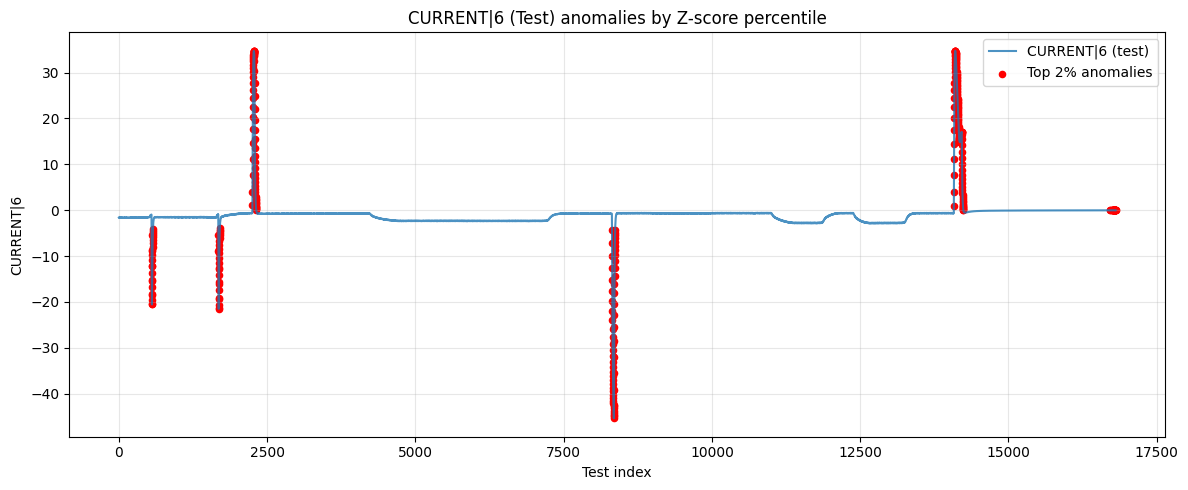

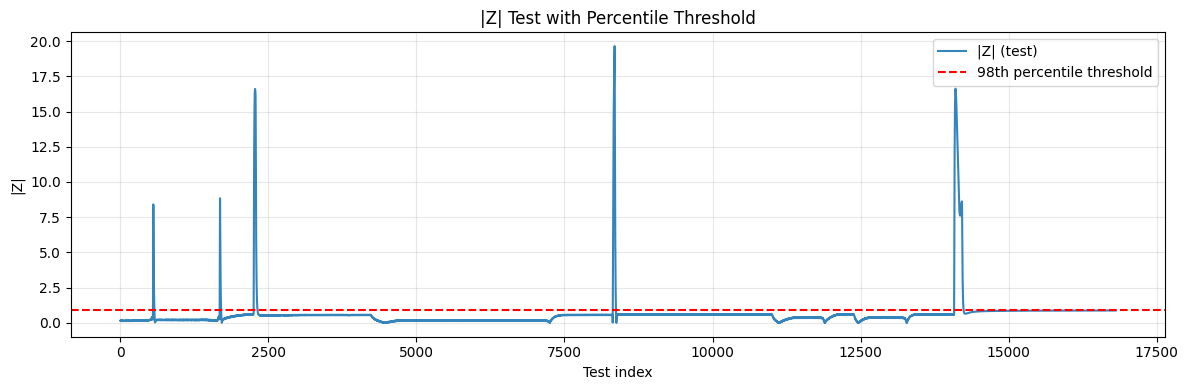

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ====== CONFIG ======
csv_path = "/content/DMC2_S_CP2_52.csv"   # <-- change path
target   = "CURRENT|6"
p        = 0.98   # top 2%

# ====== LOAD ======
df = pd.read_csv(csv_path)
y = df[target].astype(float).reset_index(drop=True)

# ====== CHRONO SPLIT 60/40 ======
n = len(y)
split_idx = int(0.6 * n)
y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

# ====== Z-SCORE (use TRAIN μ, σ) ======
mu = y_train.mean()
sigma = y_train.std(ddof=0)
if sigma == 0: sigma = 1.0
z_test = (y_test - mu) / sigma
abs_z_test = z_test.abs()

# ====== PERCENTILE THRESHOLD ======
thr = np.quantile(abs_z_test, p)
anoms = abs_z_test >= thr
num_anoms = int(anoms.sum())

print(f"Z-score {int(p*100)}th percentile threshold: {thr:.6f}")
print(f"Anomalies flagged: {num_anoms} ({100*anoms.mean():.2f}%)")

# ====== SIMPLE PLOTS ======

# Just like reconstruction error style
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label=f"{target} (test)", alpha=0.8)
plt.scatter(np.where(anoms)[0], y_test.values[anoms],
            color='red', s=20, label=f"Top {int((1-p)*100)}% anomalies")
plt.title(f"{target} (Test) anomalies by Z-score percentile")
plt.xlabel("Test index"); plt.ylabel(target)
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
plt.show()

# Optional: Z-score itself (very simple)
plt.figure(figsize=(12,4))
plt.plot(abs_z_test.values, label="|Z| (test)", alpha=0.9)
plt.axhline(thr, color="r", linestyle="--", label=f"{int(p*100)}th percentile threshold")
plt.title("|Z| Test with Percentile Threshold")
plt.xlabel("Test index"); plt.ylabel("|Z|")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
plt.show()

In [6]:
print("=== Data Statistics ===")
print(f"Training mean (μ): {mu:.4f}")
print(f"Training std (σ): {sigma:.4f}")
print(f"Test mean: {y_test.mean():.4f}")
print(f"Test std: {y_test.std(ddof=0):.4f}")

print("\n=== Z-score Info ===")
print(f"Absolute Z-score (test) max: {abs_z_test.max():.4f}")
print(f"Absolute Z-score (test) mean: {abs_z_test.mean():.4f}")
print(f"Absolute Z-score (test) std: {abs_z_test.std(ddof=0):.4f}")

print("\n=== Threshold Info ===")
print(f"Percentile threshold ({int(p*100)}%): {thr:.4f}")
print(f"Anomalies detected: {num_anoms} ({pct_anoms:.2f}%)")
print(f"Top-2% peaks: {len(top_idx)}")

=== Data Statistics ===
Training mean (μ): -1.9636
Training std (σ): 2.2099
Test mean: -1.0183
Test std: 3.3065

=== Z-score Info ===
Absolute Z-score (test) max: 19.6385
Absolute Z-score (test) mean: 0.6360
Absolute Z-score (test) std: 1.4202

=== Threshold Info ===
Percentile threshold (98%): 0.8816
Anomalies detected: 369 (2.20%)
Top-2% peaks: 16471
